# Dense Sentiment Classifier

In this notebook, we build a dense neural net to classify IMDB movie reviews by their sentiment.

#### Load dependencies

In [1]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding # new!
from keras.callbacks import ModelCheckpoint # new! 
import os # new! 
from sklearn.metrics import roc_auc_score, roc_curve # new!
import pandas as pd
import matplotlib.pyplot as plt # new!
%matplotlib inline

Using TensorFlow backend.


#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/dense'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 # as per Maas et al. (2011); may not be optimal
n_words_to_skip = 50 # ditto
max_review_length = 100
pad_type = trunc_type = 'pre'

# neural network architecture: 
n_dense = 64
dropout = 0.5

#### Load data

For a given data set: 

* the Keras text utilities [here](https://keras.io/preprocessing/text/) quickly preprocess natural language and convert it into an index
* the `keras.preprocessing.text.Tokenizer` class may do everything you need in one line:
    * tokenize into words or characters
    * `num_words`: maximum unique tokens
    * filter out punctuation
    * lower case
    * convert words to an integer index

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip) 

In [4]:
x_train[0:6] # 0 reserved for padding; 1 would be starting character; 2 is unknown; 3 is most common word, etc.

array([ [2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2],
       [2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 207, 110, 31

In [5]:
for x in x_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [6]:
y_train[0:6]

array([1, 0, 0, 1, 0, 0])

In [7]:
len(x_train), len(x_valid)

(25000, 25000)

#### Restoring words from index

In [8]:
word_index = keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

In [9]:
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [10]:
index_word = {v:k for k,v in word_index.items()}

In [11]:
x_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [12]:
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [13]:
(all_x_train,_),(all_x_valid,_) = imdb.load_data() 

In [14]:
' '.join(index_word[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### Preprocess data

In [15]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [16]:
x_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [17]:
for x in x_train[0:6]:
    print(len(x))

100
100
100
100
100
100


In [18]:
' '.join(index_word[id] for id in x_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [19]:
' '.join(index_word[id] for id in x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

#### Design neural network architecture

In [20]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(Flatten())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid')) # mathematically equivalent to softmax with two classes

In [21]:
model.summary() # so many parameters!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                409664    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [22]:
# embedding layer dimensions and parameters: 
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [23]:
# ...flatten:
max_review_length, n_dim, n_dim*max_review_length

(100, 64, 6400)

In [24]:
# ...dense:
n_dense, n_dim*max_review_length*n_dense + n_dense # weights + biases

(64, 409664)

In [25]:
# ...and output:
n_dense + 1 

65

#### Configure model

In [26]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

In [28]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [29]:
# 84.7% validation accuracy in epoch 2
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 2s - loss: 0.5402 - acc: 0.7095 - val_loss: 0.3701 - val_acc: 0.8367
Epoch 2/4
25000/25000 [==============================] - 1s - loss: 0.2825 - acc: 0.8881 - val_loss: 0.3459 - val_acc: 0.8470
Epoch 3/4
25000/25000 [==============================] - 1s - loss: 0.1279 - acc: 0.9616 - val_loss: 0.4151 - val_acc: 0.8333
Epoch 4/4
25000/25000 [==============================] - 1s - loss: 0.0303 - acc: 0.9941 - val_loss: 0.5222 - val_acc: 0.8322


#### Evaluate

In [30]:
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [31]:
y_hat = model.predict_proba(x_valid)

24032/25000 [===========================>..] - ETA: 0s

In [32]:
len(y_hat)

25000

In [33]:
y_hat[0]

array([ 0.88548595], dtype=float32)

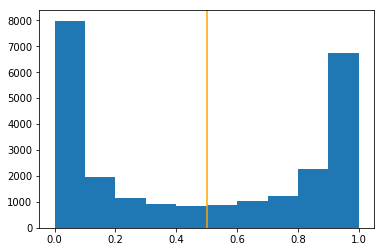

In [34]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [35]:
round(roc_auc_score(y_valid, y_hat)*100.0)

93.0

In [36]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [37]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [38]:
ydf.head(10)

,y_hat,y
0,0.885486,1
1,0.094784,1
2,0.825777,1
3,0.882278,1
4,0.316841,1
5,0.546900,0
6,0.041849,0
7,0.047915,0
8,0.955369,1
9,0.541998,1


In [39]:
' '.join(index_word[id] for id in all_x_valid[0])

'START how his charter evolved as both man and ape was outstanding not to mention the scenery of the film christopher lambert was astonishing as lord of greystoke christopher is the soul to this masterpiece i became so with his performance i could feel my heart pounding the of the movie still moves me to this day his portrayal of john was oscar worthy as he should have been nominated for it'

In [40]:
' '.join(index_word[id] for id in all_x_valid[6]) 

"START this movie is horrible you won't believe this hunk of junk is even a movie was better then this and was pretty frigging bad too a bunch of stupid teens crash in a desert find an old run down bungalow and end up fending off horrifically badly stop motion animated spiders pardon my french but the acting was bad as hell the person who wrote this probably didn't even know what a spider is because he had the spiders living in a colony serving an alien queen ripoff queen spider spiders do not live in colonies this movie is a piece of crud at the end the marines suddenly pop out of no where and kill all the spider without even being called if you see a copy of this movie at a video store it in gasoline and throw a match at it"

In [41]:
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(10)

,y_hat,y
25,0.957828,0
143,0.961272,0
150,0.933923,0
204,0.938723,0
258,0.921509,0
283,0.902109,0
304,0.943218,0
489,0.984264,0
542,0.913043,0
644,0.936996,0


In [42]:
' '.join(index_word[id] for id in all_x_valid[489]) 

"START low budget but still creepy enough to hold your interest in another take off on the familiar frankenstein story this movie is also known as lady frankenstein the alluring frankenstein sara bay fresh from medical school arrives at her father's estate to find that he is still up to his old tricks baron frankenstein joseph cotten is murdered by his own creation and now his daughter decides to carry on the family tradition by creating herself a lover this is closer to being an eerie melodrama than horror flick supporting cast features mickey hargitay paul paul muller and herbert a rainy night could amplify the atmosphere still a fun watch"

In [43]:
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
1,0.094784,1
101,0.093522,1
151,0.092449,1
239,0.043815,1
426,0.051367,1
543,0.067008,1
732,0.054247,1
926,0.081515,1
927,0.049135,1
951,0.036430,1


In [44]:
' '.join(index_word[id] for id in all_x_valid[927]) 

"START i saw it in europe plex great movie br br this film is an exploration of the spirit and the flesh in modern times protagonist jim kirk drives an unwieldy rv across america stopping often to fill his gas guzzling tank he is middle aged and confused he fuels his thick diabetic body with cups of coffee and radio chatter he is the flesh agitated and sometimes spaced out fairly oblivious to the growing tension around him but feeling it as of discomfort br br the spirit the film through speeches and other sounds as well as what appears and goes by in the visual field the spirit eventually collides with the flesh and kirk goes down unable to comprehend what has happened to him he's been in denial about just how bad things have become due to he of all of us because we are all focused on the needs and desires of our flesh we're all in the same denial and so we like kirk are in danger of going down and being blown away by desert sands just like him"